# Detection and Quantification of Microspots

---

**Updated on:** 2023-09-25

> Authors: Simon Knoblauch (simon.knoblauch@student.uni-tuebingen.de)  
> Input file(s): .tif, .png, .jpg containing spots  
> Output file(s): .csv file containing data on all detected spots  
> Dependencies: imageio, pandas, numpy, skimage, matplotlib, ipympl, pathlib, math 

**Please read the comments before proceeding to run the code and let us know if you run into any errors or find undocumented pieces of code.**

In [15]:
# Importing dependencies
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import ipympl
from pathlib import Path
import math
import microspot_util as msu
%matplotlib widget

## User Input

In [16]:
inputfile=Path(r"test_images\edge_halo.tif")
outputfolder=Path(r"output")

first_spot="A1"
last_spot="P20"

### Extracting Information from User Input

In [17]:
# Dictionaries to convert Row-Letters into Row-Numbers and vice versa.
row_conv={"abcdefghijklmnopqrstuvwxyz"[i-1]: i for i in range(1,27)}
row_conv_inv={v:k for k,v in row_conv.items()}

grid_props=msu.conv_gridinfo(first_spot,last_spot,row_conv)

## Loading the Image File

[Text(0.5, 1.0, 'Grayscale Image')]

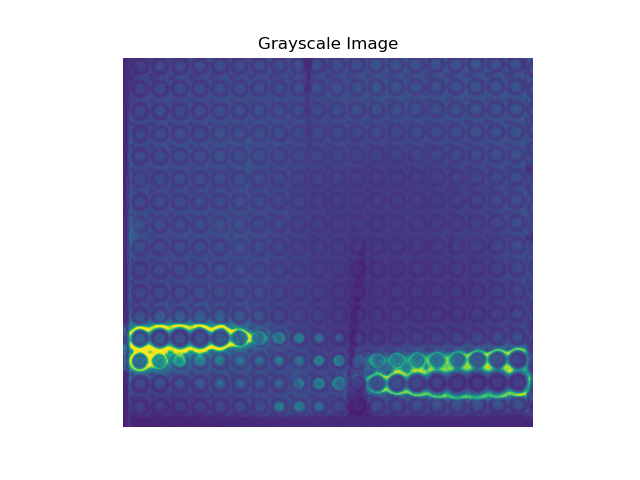

In [18]:
# Load and prepare raw image file.
raw_img=msu.prep_img(inputfile, invert=True)

# Display the grayscale image using the "viridis" colormap.
fig,ax=plt.subplots()
ax.imshow(raw_img)
ax.axis("off")
ax.set(title="Grayscale Image")


## Inital Spot and Grid detection

Spot at Coordinates (1610, 1983) could not be drawn: Out of Bounds.


[Text(0.5, 1.0, 'Detected Spot-Grid')]

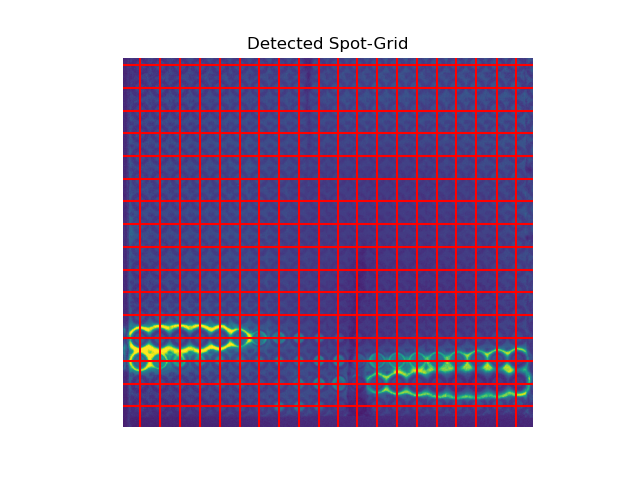

In [19]:
# Inital spot-detection.
init_spots=msu.spot.detect(raw_img,grid_props["spot_nr"])

# Create an empty image and draw a dot for each detected spot.
dot_img=np.zeros(raw_img.shape)
for i_spot in init_spots: 
    i_spot.draw_spot(dot_img,255,5)

# Detection of gridlines.
gridlines=msu.gridline.detect(dot_img)
hor_line=[line for line in gridlines if line.alignment=="hor"]
vert_line=[line for line in gridlines if line.alignment=="vert"]

# Calculate the intersections of all horizontal lines with all vertical lines.
grid_points=[]
for h_l in hor_line:
    for v_l in vert_line:
        grid_points.append(v_l.intersect(h_l))

# Display the grid.
fig,ax=plt.subplots()
ax.imshow(raw_img)
for item in hor_line+vert_line:
    ax.axline((0,item.y_int), slope=item.slope,c="r")
ax.set(ylim=[raw_img.shape[0],0],xlim=[0,raw_img.shape[1]])
ax.axis("off")
ax.set(title="Detected Spot-Grid")

## Spot Correction, Sorting and Intensity Determination

In [20]:
# Initializing corrected spotlist
corr_spots=[]

# Loop over all spots and gridpoints
for s_point in init_spots:
    dist_list=[]
    for g_point in grid_points:

        # Calculate the distance between the points and append it to the running list.
        pointdist=g_point.eval_distance(s_point.x,s_point.y)
        dist_list.append(pointdist)
    
    # If the distance between the current spot and any gridpoint is <= it is accepted as correct.
    if min(dist_list)<=10:
        corr_spots.append(s_point)

# Loop over all gridpoints and backfill the ones that are not associated with a spot.
for g_point in grid_points:
    if g_point.min_dist>10:
        msu.spot.backfill(corr_spots,g_point.x,g_point.y)

sort_spots=msu.spot.sort_grid(corr_spots,
                            row_conv=row_conv_inv,
                            row_start=grid_props["rows"]["bounds"][0],
                            col_start=grid_props["columns"]["bounds"][0])

for s in sort_spots:
    s.get_intensity(raw_img)

## Halo Detection

In [21]:
# Detect Halos using the halo.detect method.
halos=msu.halo.detect(raw_img)
halo_df=msu.halo.create_df(halos)

# Assign halos to their spot.
for s in sort_spots:
    s.assign_halo(halos)


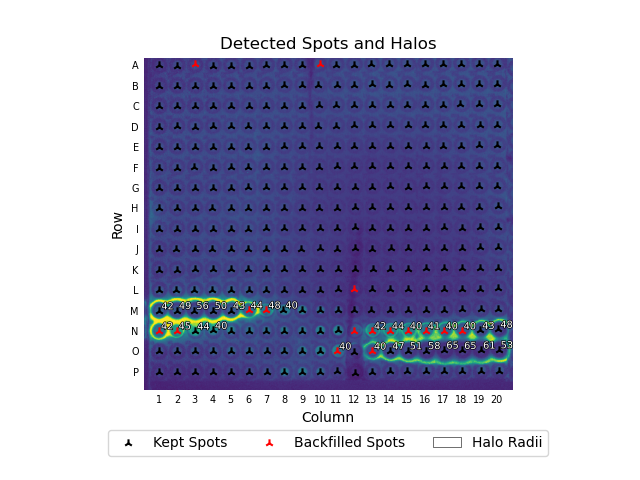

In [22]:
# Display the corrected and sorted spotlist.
sort_spot=msu.spot.create_df(sort_spots)

fig,ax=plt.subplots()
ax.imshow(raw_img)
ax.scatter(sort_spot.loc[sort_spot["note"]=="Initial Detection","x_coord"],sort_spot.loc[sort_spot["note"]=="Initial Detection","y_coord"],marker="2",c="k",label="Kept Spots")
ax.scatter(sort_spot.loc[sort_spot["note"]=="Backfilled","x_coord"],sort_spot.loc[sort_spot["note"]=="Backfilled","y_coord"],marker="2",c="r",label="Backfilled Spots")
ax.set(title="Detected Spots and Halos",
       ylabel="Row",
       xlabel="Column",
       yticks=sort_spot[sort_spot["column"]==grid_props["columns"]["bounds"][0]]["y_coord"],
       yticklabels=sort_spot[sort_spot["column"]==grid_props["columns"]["bounds"][0]]["row_name"],
       xticks=sort_spot[sort_spot["row"]==grid_props["rows"]["bounds"][0]]["x_coord"],
       xticklabels=sort_spot[sort_spot["row"]==grid_props["rows"]["bounds"][0]]["column"],
       )
ax.spines[["right","left","top","bottom"]].set_visible(False)
ax.tick_params(axis=u'both', which=u'both',length=0,labelsize=7)

# Adding legend handles for Text
handles,lables=ax.get_legend_handles_labels()
patch=mpl.patches.Patch(facecolor="white",edgecolor="k",linewidth=0.4,label="Halo Radii")
handles.append(patch)
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])
ax.legend(handles=handles,loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True,ncol=5)

# Displaying all detected Halos with their respective radii.
halo_df=sort_spot[sort_spot["halo"]>0]
for idx in halo_df.index:
    ax.text(halo_df.loc[idx,"x_coord"]+12, halo_df.loc[idx,"y_coord"]-9, f'{halo_df.loc[idx,"halo"]:.0f}',c="white",size=7,path_effects=[mpl.patheffects.withStroke(linewidth=1, foreground="k")])


## Heatmap

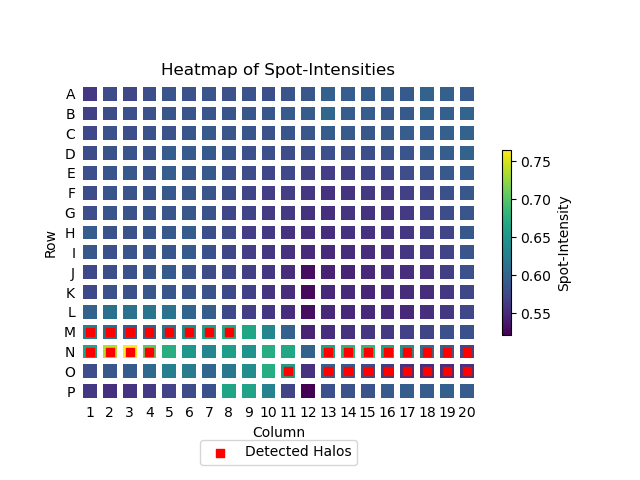

In [23]:
sort_df=msu.spot.create_df(sort_spots)
heatmap=sort_df.pivot_table(index="row_name",columns="column",values="spot_intensity")

# Display Image and corresponding Heatmap
fig,ax=plt.subplots()
htmp=ax.pcolormesh(heatmap.iloc[::-1],edgecolors="white",linewidth=4)
ax.set(title="Heatmap of Spot-Intensities",
          aspect="equal",
          ylabel="Row",
          xlabel="Column",
          yticks=np.array(range(1,len(heatmap)+1))-0.5,
          xticks=np.array(range(1,len(heatmap.columns)+1))-0.5,
          yticklabels=heatmap.index[::-1],
          xticklabels=heatmap.columns
          )
ax.spines[["right","left","top","bottom"]].set_visible(False)
ax.tick_params(axis=u'both', which=u'both',length=0)
ax.scatter(sort_df.loc[sort_df["halo"]>0,"column"]-(math.floor((grid_props["columns"]["bounds"][0])/10)*10)-0.5,grid_props["rows"]["bounds"][-1]+0.5-sort_df.loc[sort_df["halo"]>0,"row"],marker="s", c="red",label="Detected Halos")
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True,ncol=5)
fig.colorbar(htmp,ax=ax,label="Spot-Intensity",shrink=0.5)

## Save Results

In [24]:
# Create the output-folder if it does not exist already
if not outputfolder.exists():
    outputfolder.mkdir()

# Generate path for output-file
filename=inputfile.name.split(".")[0]+"_spotlist.csv"
outputfile=outputfolder/filename

# Write a csv-file of the results.
sort_df.to_csv(outputfile)